In [85]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors 

In [162]:
def properties_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    properties = {
    'Molecular weight': Descriptors.MolWt(mol),
    'LogP': Descriptors.MolLogP(mol),
    'Number of HBD': Descriptors.NumHDonors(mol),
    'Number of HBA': Descriptors.NumHAcceptors(mol),
    'Number of heteroatoms': Descriptors.NumHeteroatoms(mol),
    'TPSA': Descriptors.TPSA(mol),
    'Number of Aromatic Rings': Descriptors.NumAromaticRings(mol),
    'Fraction of sp3 atoms': Descriptors.FractionCSP3(mol),
    }
    return pd.Series(properties)


class DataAnalyser():
    
    def __init__(self, protein, dtype=['smiles', 'klek_balanced', 'klek_100nM'], smiles_col='SMILES'):
        sys.path.append('..')
        self.protein = protein
        self.smiles_col = smiles_col
        if dtype == 'smiles':
            self.data_path = f"./smiles/{protein}_{dtype}.csv"
        elif dtype == 'klek_balanced':
            self.data_path = f"./klek_clean/{protein}_{dtype}.csv"
        elif dtype == 'klek_100nM':
            self.data_path = f"./klek_clean/{protein}_{dtype}.csv"
        self.df = pd.read_csv(self.data_path, sep=',')
        self.df = pd.concat([self.df, self.df[self.smiles_col].apply(properties_from_smiles)], axis=1)
        self.df['pKi'] = self.df['Ki'].apply(np.log10)
        self.disc_properties = ['Number of HBD', 'Number of HBA', 'Number of heteroatoms', 'Number of Aromatic Rings']
        self.cont_properties = ['LogP', 'Molecular weight', 'TPSA', 'Fraction of sp3 atoms']
    
    def plot_distribution(self, column):
        sns.set_style('white')
        sns.set_context('talk')
        class_0_mean = np.mean(self.df[self.df['Class'] == 0][column])
        class_1_mean = np.mean(self.df[self.df['Class'] == 1][column])
        class_0_std = np.mean(self.df[self.df['Class'] == 0][column])
        class_1_std = np.mean(self.df[self.df['Class'] == 1][column])
        self.df = self.df[np.logical_and(self.df[column] > (class_0_mean - 2 * class_0_std), self.df[column] < (class_0_mean + 2 * class_0_std))]
        self.df = self.df[np.logical_and(self.df[column] > (class_1_mean - 2 * class_1_std), self.df[column] < (class_1_mean + 2 * class_1_std))]
        if column in self.cont_properties:
            ax = sns.histplot(data=self.df, x=column, hue="Class", kde=True)
            plt.title(f"Distribution of {column} for ligands of {self.protein.upper()}")
            plt.ylabel("Count")
        elif column in self.disc_properties:
            ax = sns.countplot(data=self.df, x=column, hue="Class")
            plt.title(f"{column} for ligands of {self.protein.upper()}")
            plt.xticks(ticks=plt.xticks()[0], labels = [int(x) for x in plt.xticks()[0]])
            plt.ylabel("Count")
        else:
            print(f"Column {column} not found")
        ax.axvline(class_0_mean, 0, 1, color='blue')
        ax.axvline(class_1_mean, 0, 1, color='orange')
        save_path = f"./figures/{self.protein}/{self.protein}_{column}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

In [163]:
data = DataAnalyser('d2', 'klek_balanced')

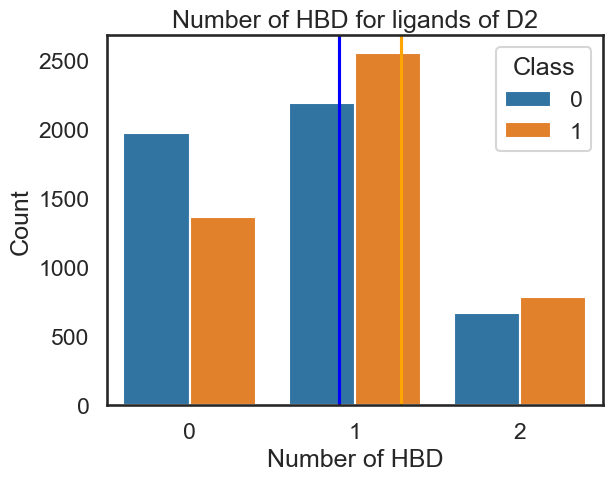

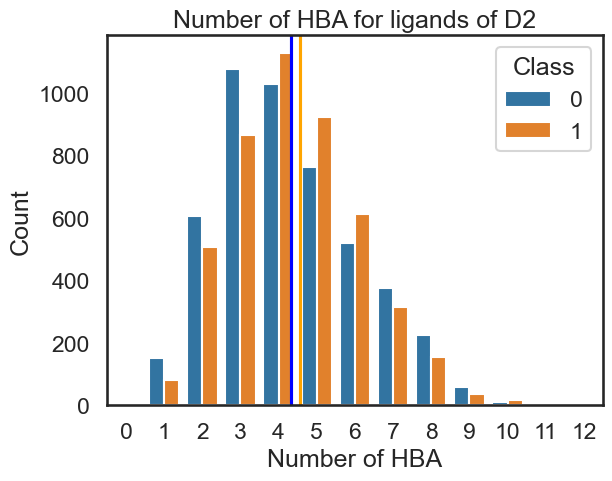

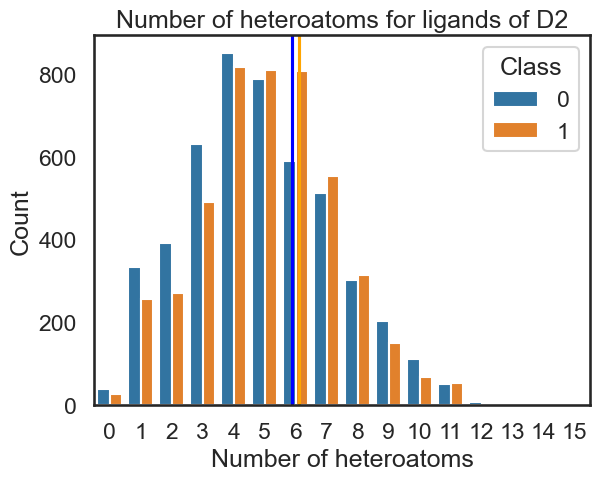

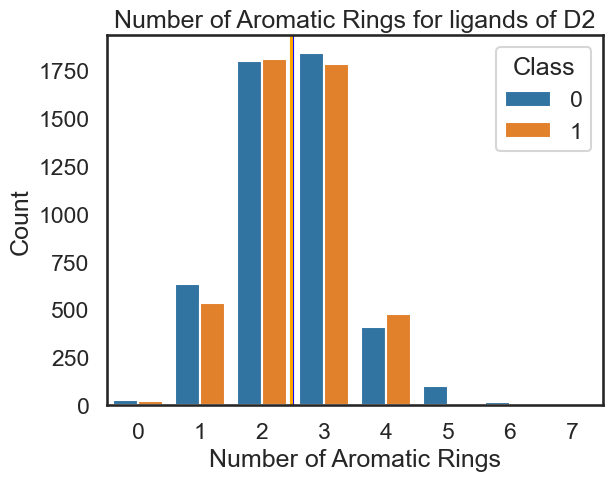

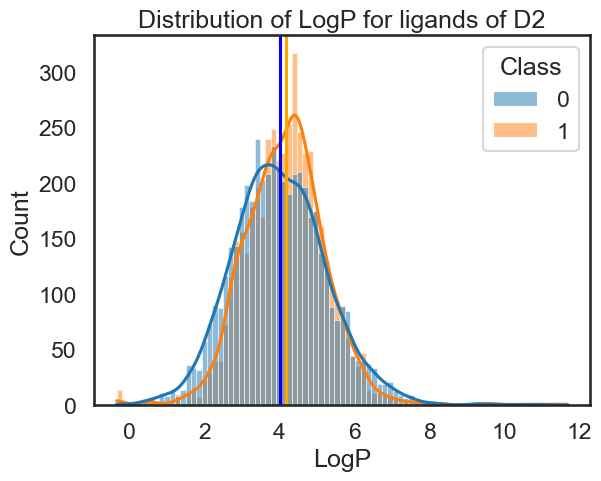

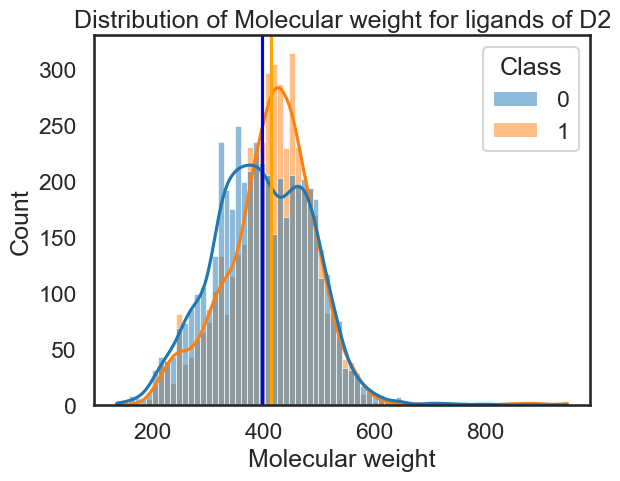

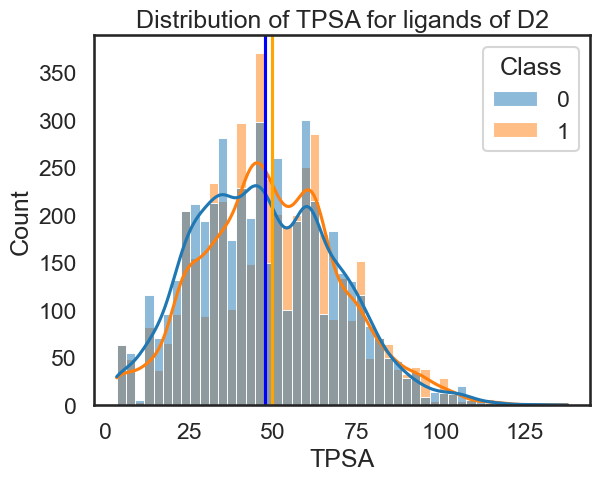

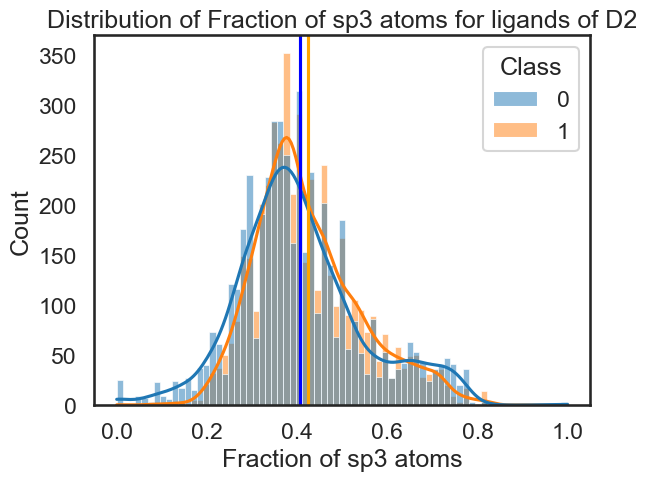

In [164]:
for attribute in data.disc_properties:
    data.plot_distribution(attribute)

for attribute in data.cont_properties:
    data.plot_distribution(attribute)

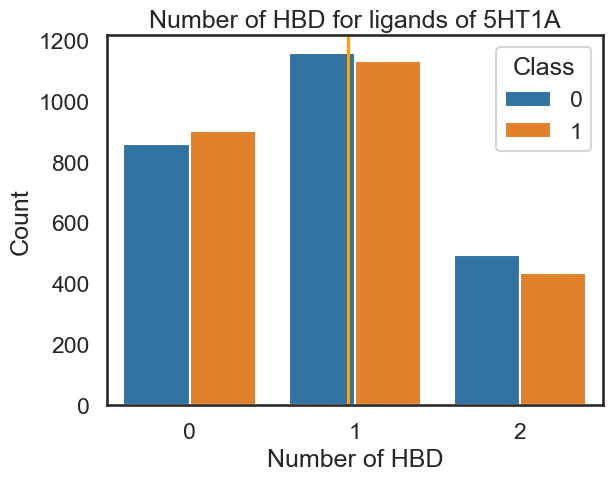

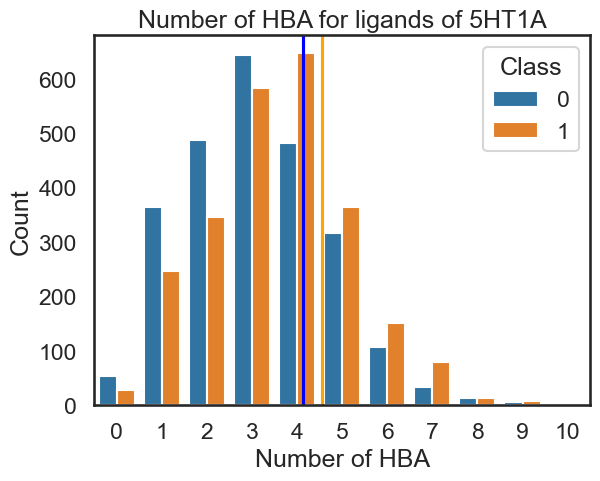

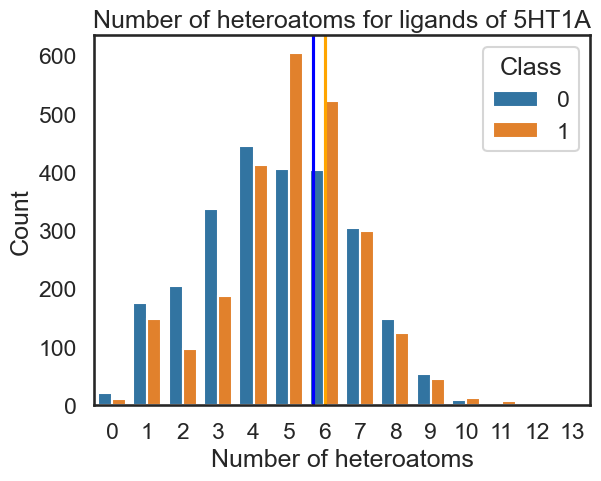

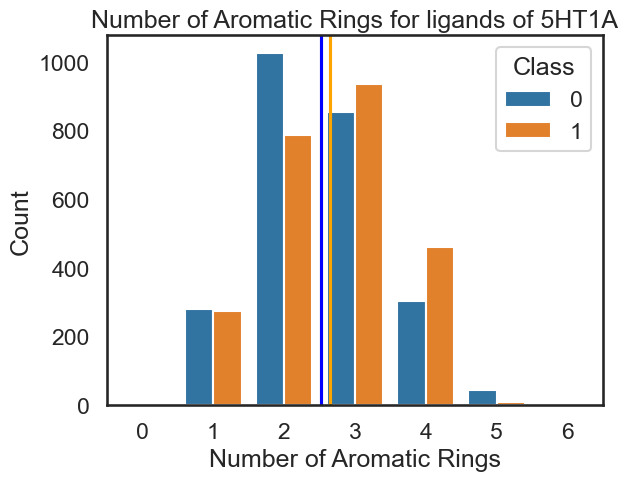

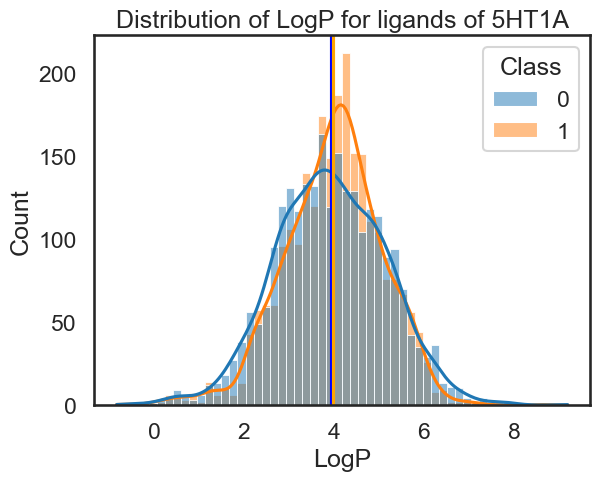

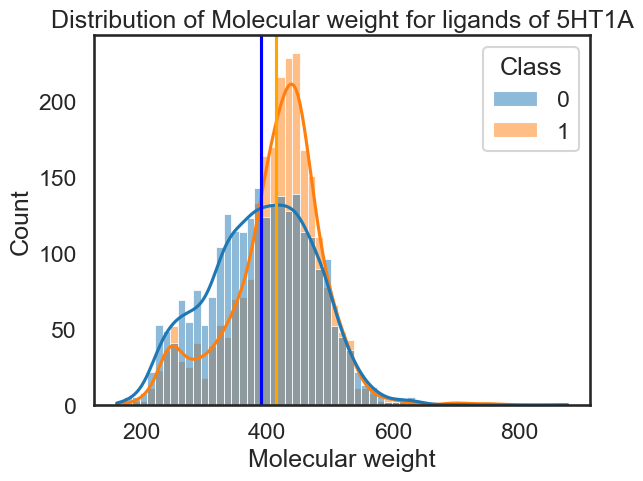

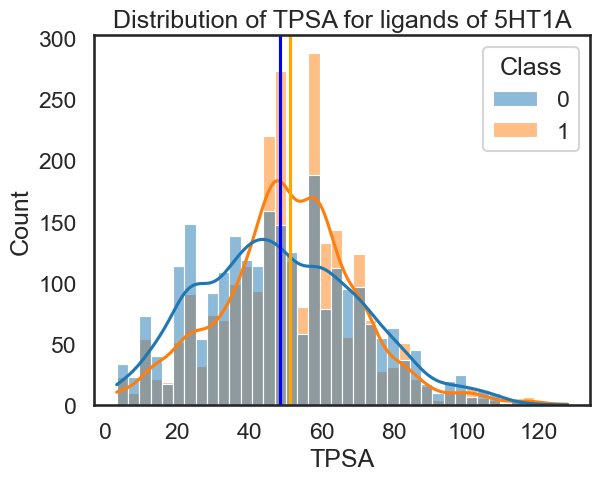

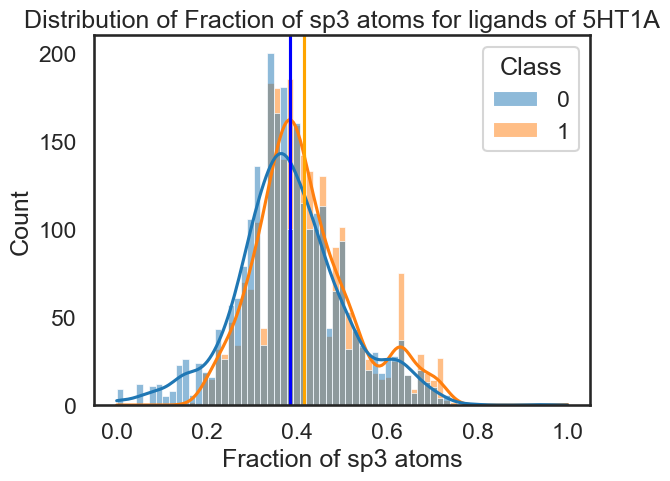

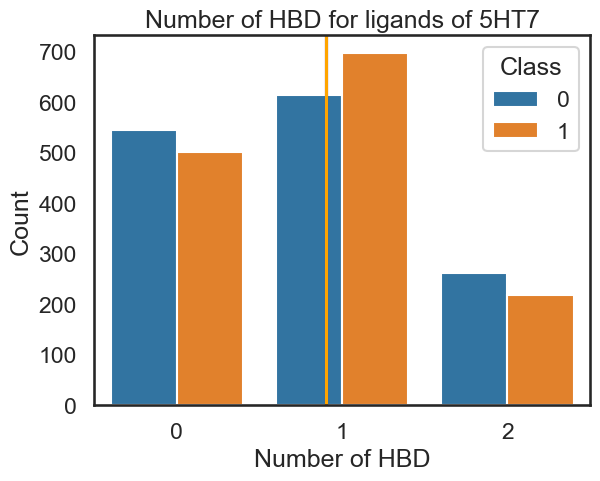

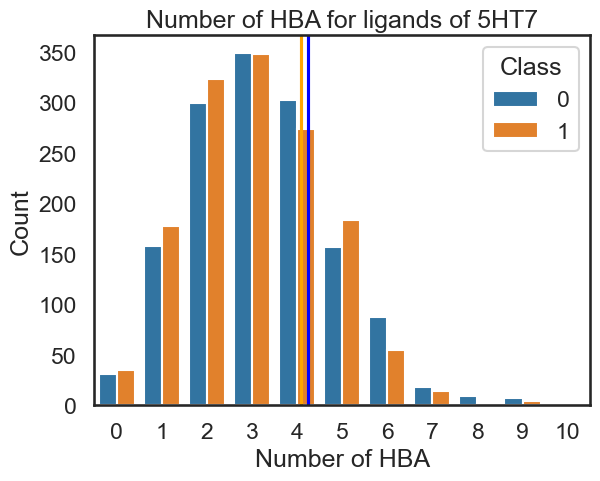

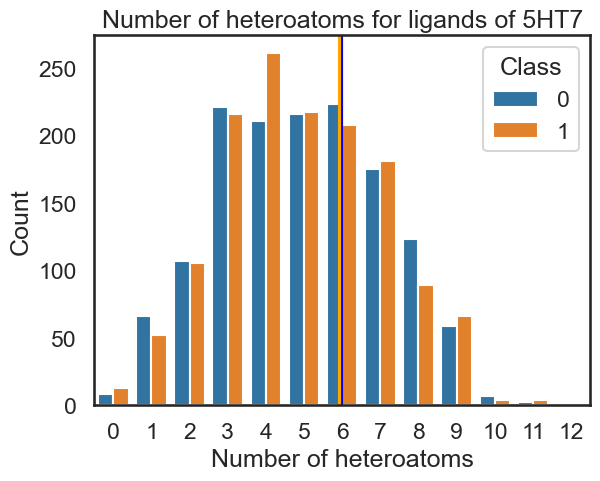

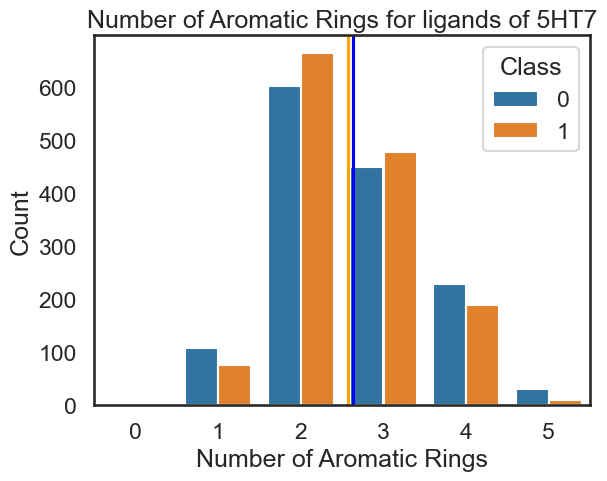

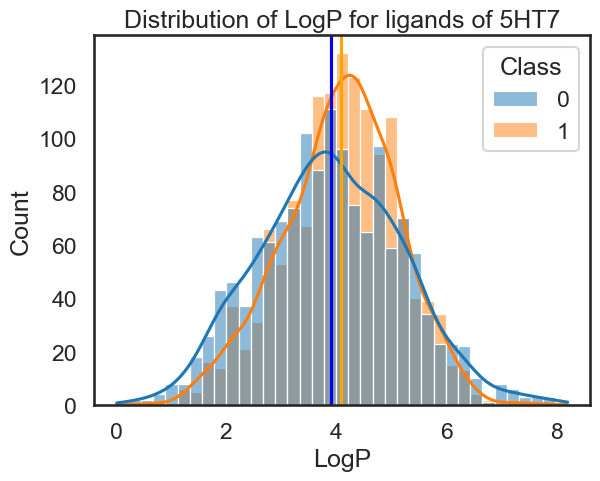

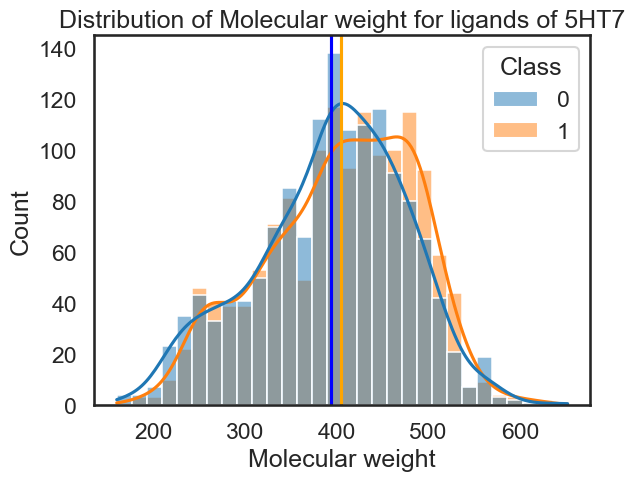

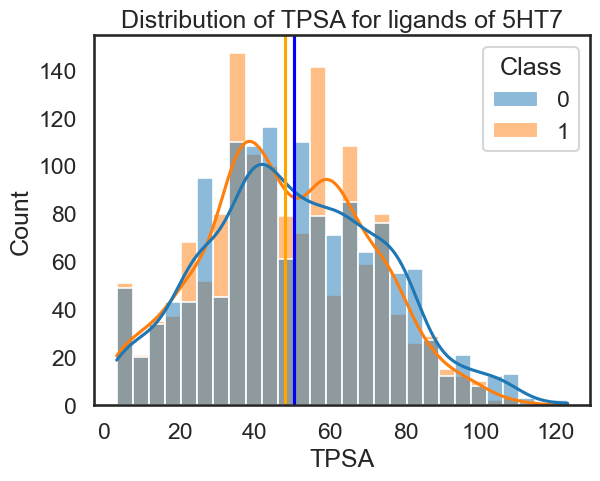

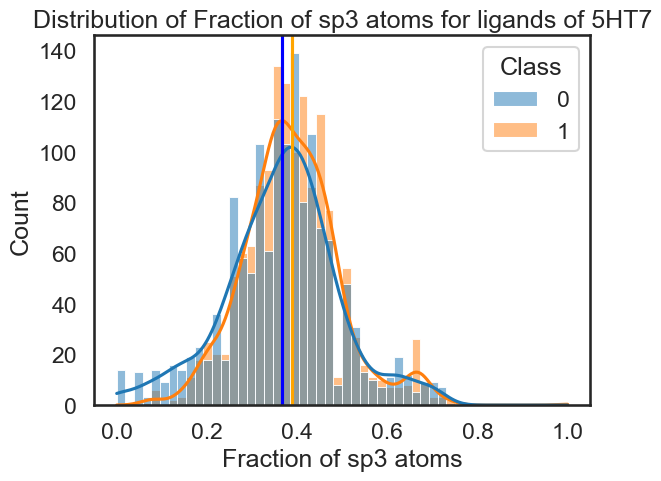

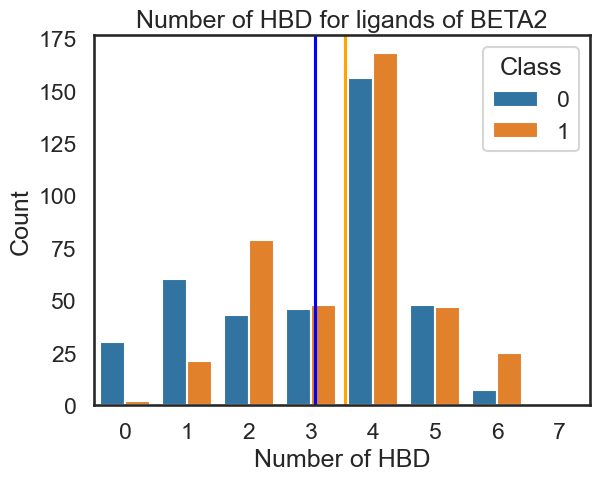

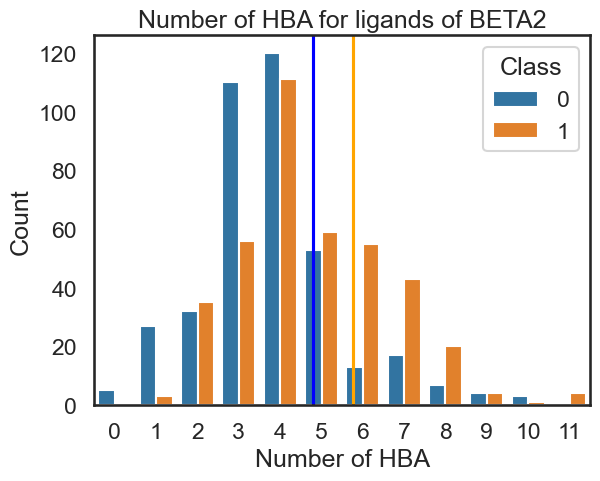

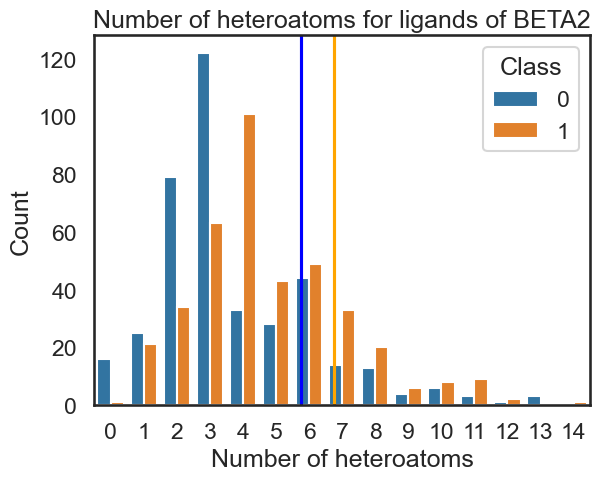

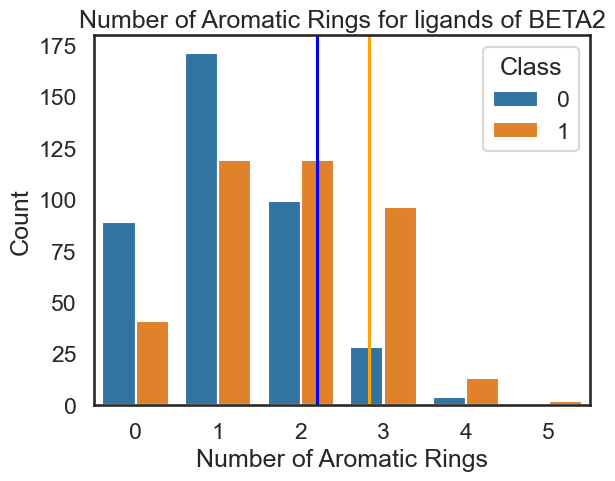

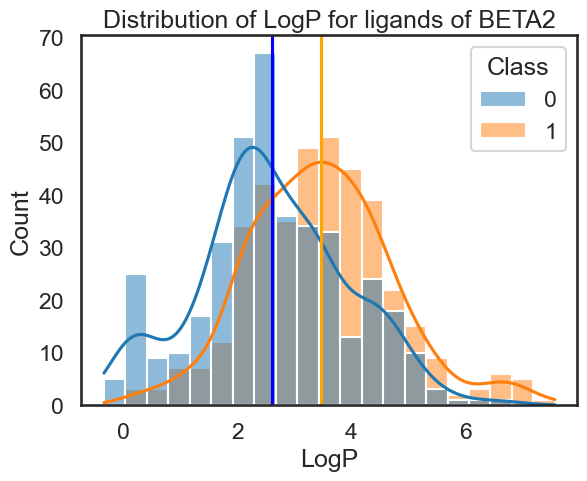

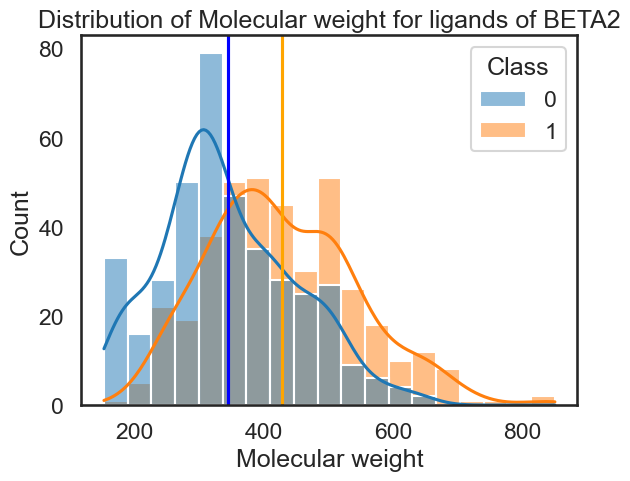

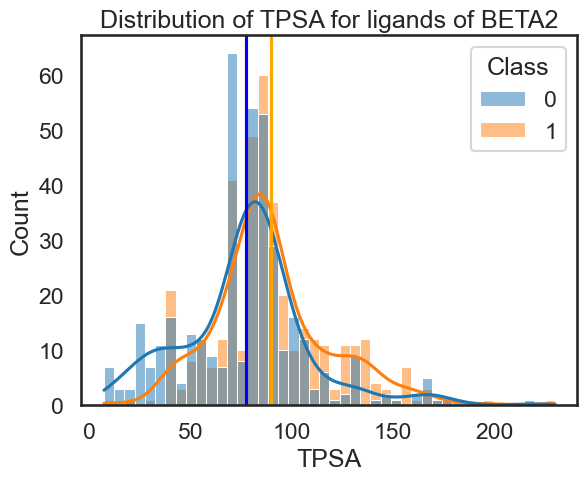

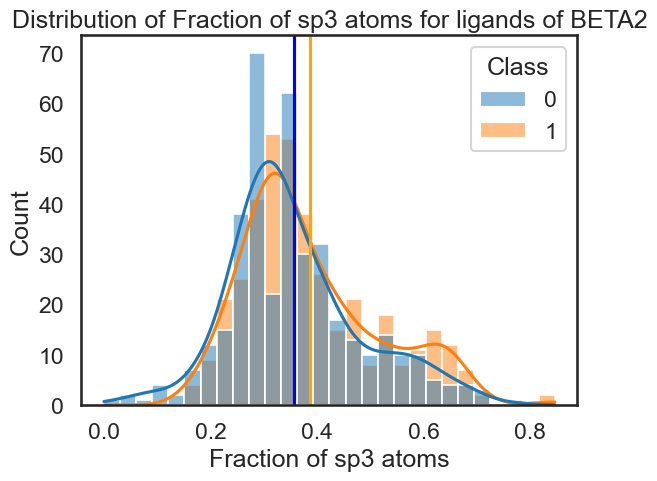

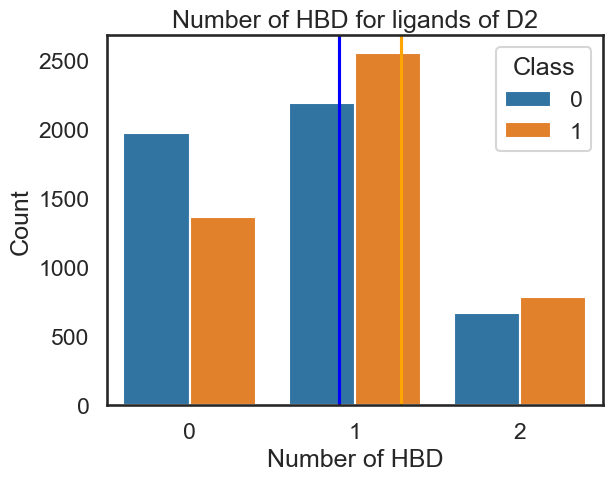

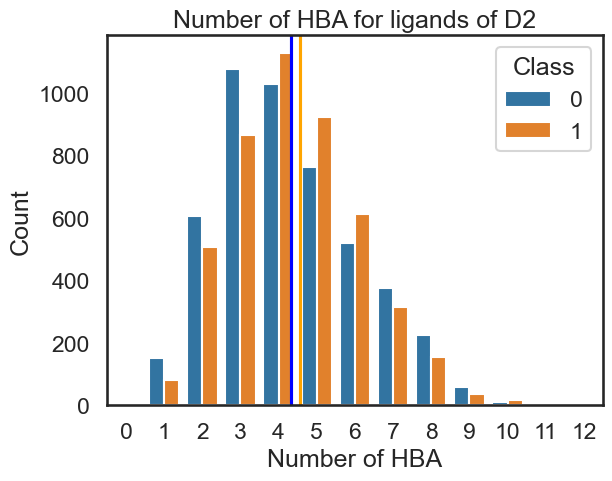

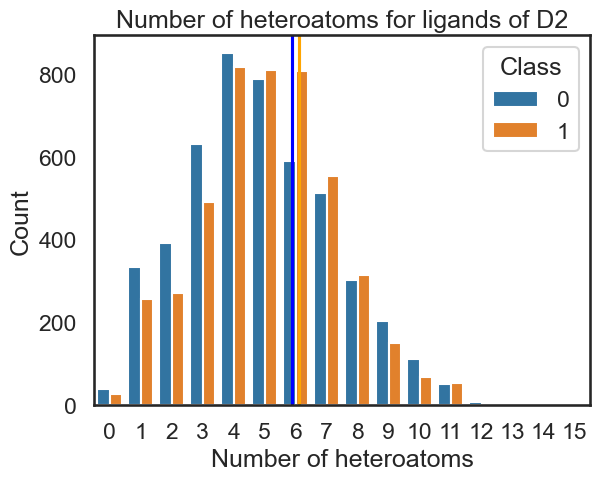

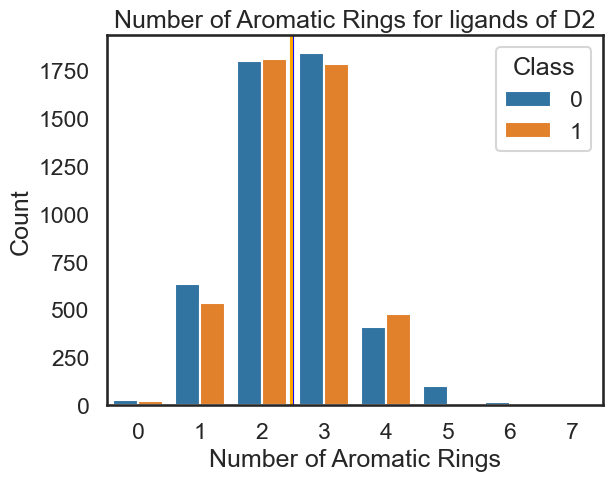

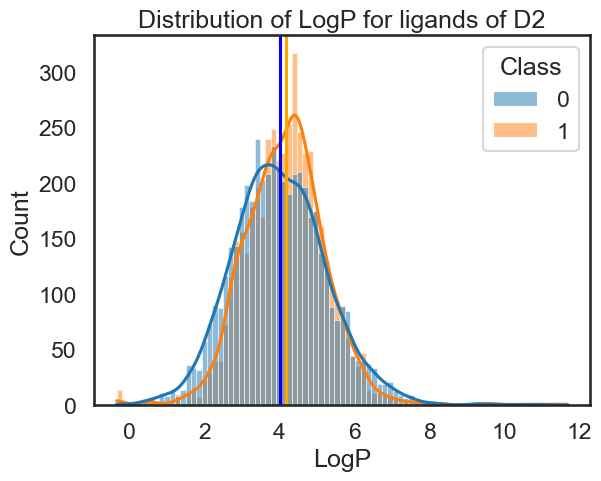

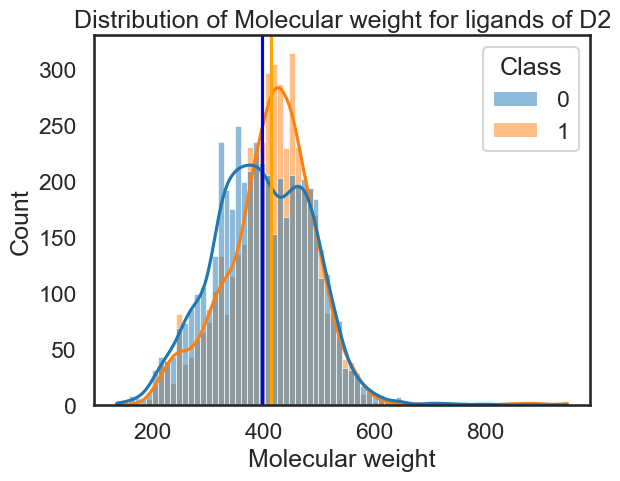

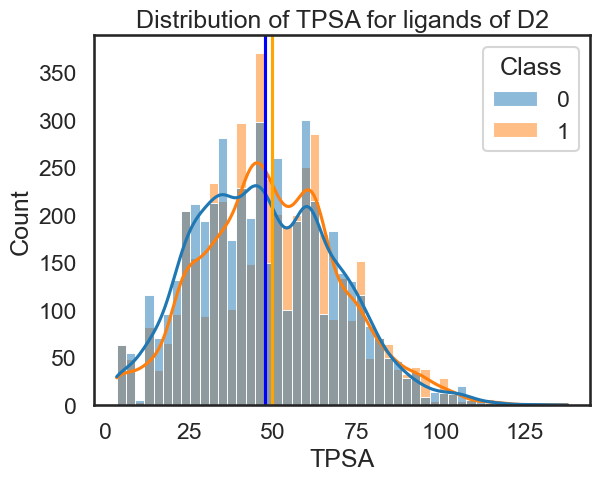

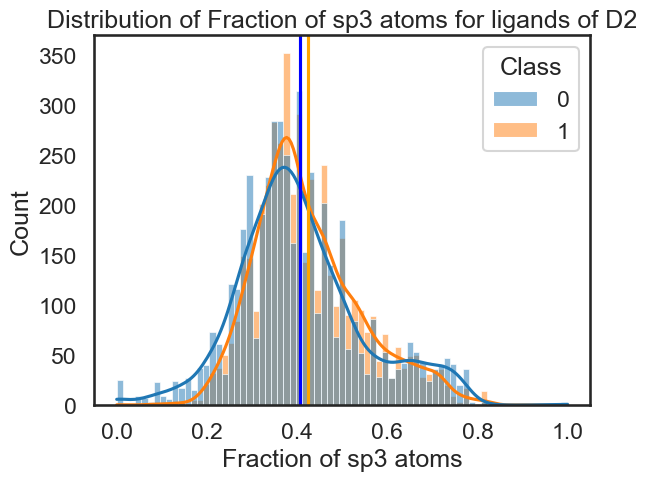

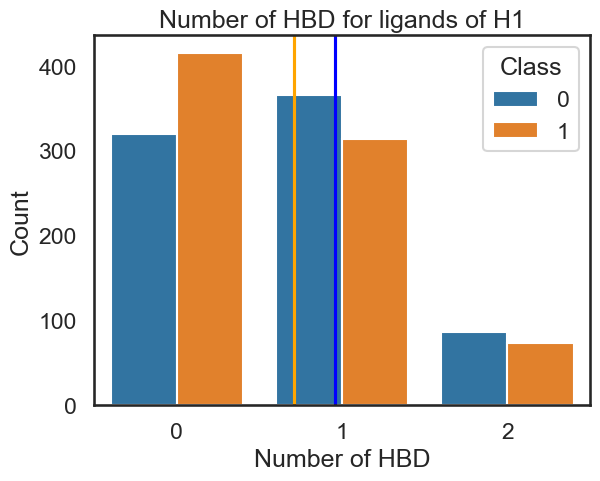

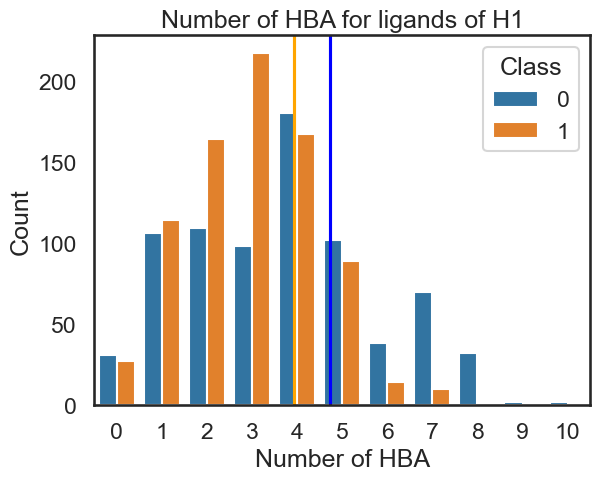

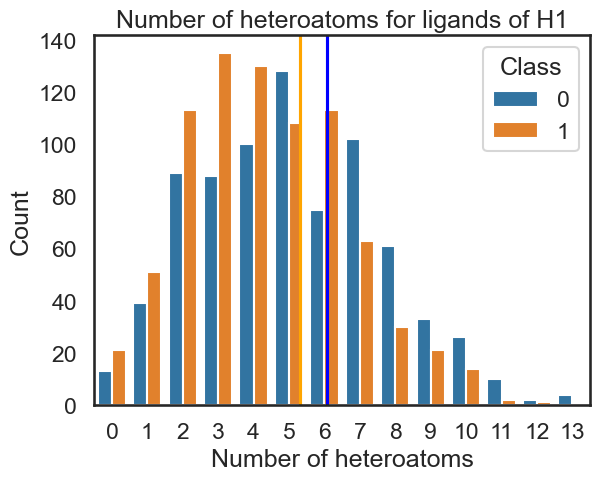

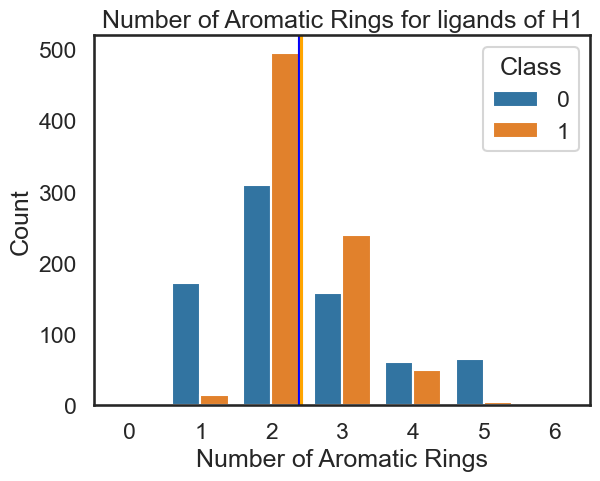

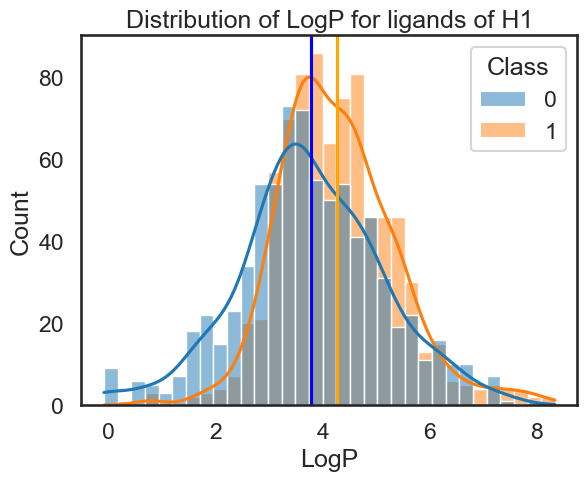

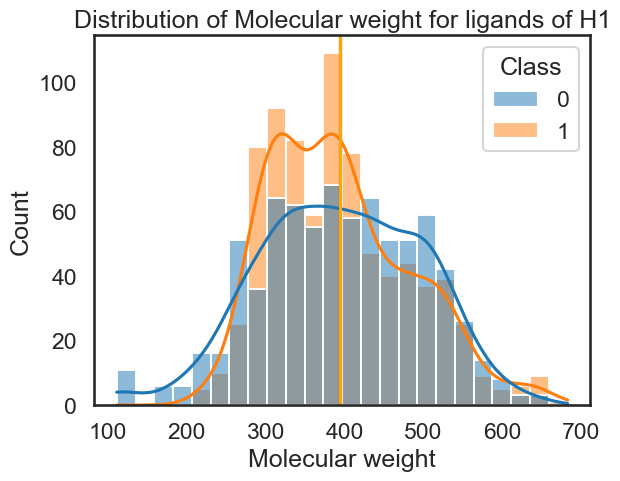

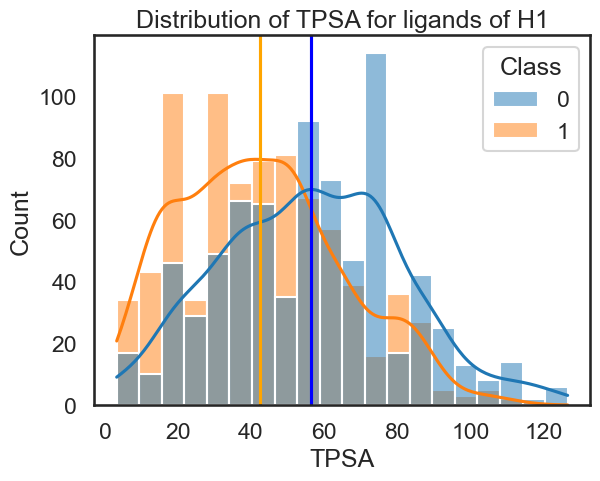

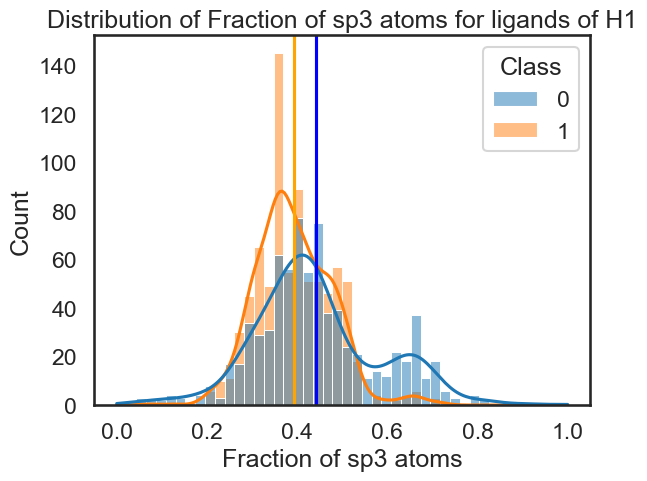

In [165]:
proteins = ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']
for protein in proteins:
    data = DataAnalyser(protein, 'klek_balanced')
    for attribute in data.disc_properties + data.cont_properties:
        data.plot_distribution(attribute)